<a href="https://colab.research.google.com/github/fawadmehboob/GrigWorld_DQN_RL/blob/main/RL_2D_GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import torch.optim as optim
from IPython.display import HTML
import matplotlib.patches as patches
from collections import deque
from matplotlib import animation

# Define the Environment

In [2]:
import numpy as np

class GridWorldEnv:
    def __init__(self, grid_size=5, num_walls=5):
        self.grid_size = grid_size
        self.num_walls = num_walls
        self.goal_pos = (grid_size - 1, grid_size - 1)
        self.agent_pos = (0, 0)
        hardcoded_walls = [(1, 2), (2, 1), (3, 3), (2, 2), (1, 3)]  # Example for 5x5
        self.walls = set([(x, y) for (x, y) in hardcoded_walls if (x, y) != self.agent_pos and (x, y) != self.goal_pos])
        self.wall_positions = list(self.walls)
        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.grid[self.goal_pos] = 2
        for (x, y) in self.walls:
            self.grid[x, y] = 1
        self.agent_pos = (0, 0)
        return self.agent_pos

    def render(self):
        display_grid = np.copy(self.grid)
        x, y = self.agent_pos
        display_grid[x, y] = 3
        print(display_grid)

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y  # Default to current position

        # Move based on action
        if action == 0:       # Up
            new_x -= 1
        elif action == 1:     # Down
            new_x += 1
        elif action == 2:     # Left
            new_y -= 1
        elif action == 3:     # Right
            new_y += 1

        reward = -0.001  # Step penalty
        done = False     # Initialize done

        # Check bounds and walls
        if (0 <= new_x < self.grid_size) and (0 <= new_y < self.grid_size):
            if (new_x, new_y) in self.walls:
                reward -= 0.5  # Penalty for hitting a wall
            else:
                self.agent_pos = (new_x, new_y)  # Valid move
        else:
            reward -= 0.5  # Penalty for out-of-bounds move

        # Check goal
        if self.agent_pos == self.goal_pos:
            reward += 10  # Goal reward
            done = True

        return self.agent_pos, reward, done

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [4]:
env = GridWorldEnv()
env.render()

[[3 0 0 0 0]
 [0 0 1 1 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 2]]


# Defining the DQN

In [5]:
class DQN(nn.Module):
  def __init__(self, input_dim=2, output_dim=4):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(input_dim , 64)
    self.fc2 = nn.Linear(64,64)
    self.out = nn.Linear(64,output_dim)

  def forward(self, x):
    x =F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return self.out(x)



# Define the Agent

In [10]:
class Agent:
    def __init__(self, model, grid_size=5):
        self.epsilon = 1.0
        self.model = model
        self.grid_size = grid_size
        self.device = next(model.parameters()).device  # Get device from model parameters

    def select_action(self, state):
        if random.random() < self.epsilon:
            action = random.randint(0, 3)
        else:
            state_tensor = torch.FloatTensor([state[0]/self.grid_size, state[1]/self.grid_size]).unsqueeze(0).to(self.device)
            q_values = self.model(state_tensor)
            action = torch.argmax(q_values, dim=1).item()
        return action

# Training Loop

In [11]:
# Hyperparameters
learning_rate = 0.0005
gamma = 0.95
max_episodes = 10000
max_steps = 200
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 2000
batch_size = 64
target_update_freq = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN().to(device)
target_model = DQN().to(device)
target_model.load_state_dict(model.state_dict())
target_model.eval()
agent = Agent(model, grid_size=5)  # Update grid_size for 5x5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
buffer = ReplayBuffer(capacity=10000)
episode_rewards = []
losses = []
global_step = 0

for episode in range(max_episodes):
    agent.epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        global_step += 1
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        buffer.push(state, action, reward, next_state, done)

        if len(buffer) >= batch_size:
            transitions = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*transitions)

            states = torch.FloatTensor([[s[0]/env.grid_size, s[1]/env.grid_size] for s in states]).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor([[s[0]/env.grid_size, s[1]/env.grid_size] for s in next_states]).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = agent.model(states)
            current_q = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                next_q_values = target_model(next_states)
                max_next_q = next_q_values.max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)

            loss = F.mse_loss(current_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            losses.append(loss.item())

        if global_step % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())

        state = next_state
        if done:
            break

    episode_rewards.append(total_reward)
    if (episode + 1) % 100 == 0:
        avg_reward = sum(episode_rewards[-100:]) / 100
        avg_loss = sum(losses[-100:]) / 100 if losses else 0
        print(f"Episode {episode + 1}, Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}, Epsilon: {agent.epsilon:.2f}")

# Save model
torch.save(model.state_dict(), "dqn_model.pth")


Episode 100, Avg Reward: -12.43, Avg Loss: 0.0035, Epsilon: 0.95
Episode 200, Avg Reward: -4.25, Avg Loss: 0.0001, Epsilon: 0.91
Episode 300, Avg Reward: -0.14, Avg Loss: 0.0000, Epsilon: 0.87
Episode 400, Avg Reward: 2.90, Avg Loss: 0.0000, Epsilon: 0.83
Episode 500, Avg Reward: 3.41, Avg Loss: 0.0000, Epsilon: 0.79
Episode 600, Avg Reward: 5.45, Avg Loss: 0.0000, Epsilon: 0.75
Episode 700, Avg Reward: 5.98, Avg Loss: 0.0000, Epsilon: 0.72
Episode 800, Avg Reward: 6.57, Avg Loss: 0.0000, Epsilon: 0.69
Episode 900, Avg Reward: 6.70, Avg Loss: 0.0000, Epsilon: 0.66
Episode 1000, Avg Reward: 7.09, Avg Loss: 0.0000, Epsilon: 0.63
Episode 1100, Avg Reward: 7.22, Avg Loss: 0.0000, Epsilon: 0.60
Episode 1200, Avg Reward: 7.61, Avg Loss: 0.0000, Epsilon: 0.57
Episode 1300, Avg Reward: 8.13, Avg Loss: 0.0000, Epsilon: 0.55
Episode 1400, Avg Reward: 8.28, Avg Loss: 0.0000, Epsilon: 0.52
Episode 1500, Avg Reward: 8.46, Avg Loss: 0.0000, Epsilon: 0.50
Episode 1600, Avg Reward: 8.54, Avg Loss: 0.0

NameError: name 'moving_average' is not defined

# Animation

In [17]:
class GridWorldAnimation:
    def __init__(self, env, agent, max_steps=100):
        self.env = env
        self.agent = agent
        self.agent_positions = []
        self.max_steps = max_steps

    def run_episode(self):
        state = self.env.reset()
        self.agent_positions = [tuple(self.env.agent_pos)]  # Store initial position
        done = False
        step = 0

        while not done and step < self.max_steps:
            action = self.agent.select_action(state)
            next_state, reward, done = self.env.step(action)
            self.agent_positions.append(tuple(self.env.agent_pos))
            state = next_state
            step += 1

        if not done:
            print("⚠️ Episode did not complete within max steps.")

    def animate(self):
        self.run_episode()
        print(f"Recorded {len(self.agent_positions)} positions.")

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, self.env.grid_size)
        ax.set_ylim(0, self.env.grid_size)
        ax.set_xticks(range(self.env.grid_size + 1))
        ax.set_yticks(range(self.env.grid_size + 1))
        ax.grid(True)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')

        # Draw walls
        for wall in self.env.wall_positions:
            wall_patch = patches.Rectangle((wall[1], wall[0]), 1, 1, color='black')  # (column, row)
            ax.add_patch(wall_patch)

        # Draw goal
        goal_patch = patches.Rectangle((self.env.goal_pos[1], self.env.goal_pos[0]), 1, 1, color='green')
        ax.add_patch(goal_patch)

        # Draw agent at initial position
        initial_pos = self.agent_positions[0]
        agent_patch = patches.Circle((initial_pos[1] + 0.5, initial_pos[0] + 0.5), 0.3, color='blue')
        ax.add_patch(agent_patch)

        def update(frame_idx):
            pos = self.agent_positions[frame_idx]
            agent_patch.center = (pos[1] + 0.5, pos[0] + 0.5)  # (column, row)
            return agent_patch,

        ani = animation.FuncAnimation(
            fig, update, frames=len(self.agent_positions),
            interval=300, blit=True, repeat=False
        )
        plt.close(fig)

        return HTML(ani.to_jshtml())

In [18]:
eval_agent = Agent(model, grid_size=5)
eval_agent.epsilon = 0.0  # Greedy policy
animator = GridWorldAnimation(env, eval_agent)
display(animator.animate())

Recorded 9 positions.


# Plotting

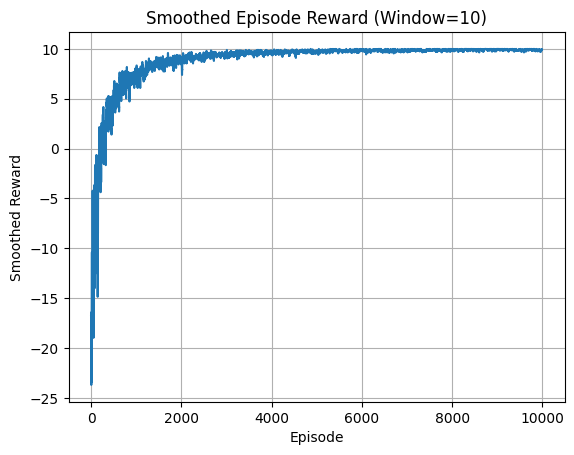

In [15]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = moving_average(episode_rewards)

plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Reward')
plt.title('Smoothed Episode Reward (Window=10)')
plt.grid(True)
plt.show()

In [16]:
print(np.max(episode_rewards))

9.992
